Author: [YANG Jiancheng](https://github.com/duducheng)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import pairwise_distances

% matplotlib inline

In [2]:
def make_clusters(skew=True, *arg,**kwargs):
    X, y = datasets.make_blobs(*arg,**kwargs)
    if skew:
        nrow = X.shape[1]
        for i in np.unique(y):
            X[y==i] = X[y==i].dot(np.random.random((nrow,nrow))-0.5)
    return X,y

In [3]:
def scatter(X, color=None, ax=None, centroids=None):
    assert X.shape[1]==2
    if color is not None:
        assert X.shape[0]==color.shape[0]
        assert len(color.shape)==1
    if not ax:
        _, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=color)
    if centroids is not None:
        ax.scatter(centroids[:,0],centroids[::,1], marker="o",s=350, c=range(centroids.shape[0]))

(1500, 2)
(1500,)
[0 1 2]


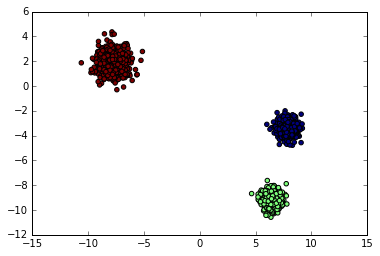

In [4]:
np.random.seed(6)

K = 3
X, y = make_clusters(skew=False, n_samples=1500, centers=K, cluster_std=[.5,.5,.8])
answer = y
print(X.shape)
print(y.shape)
print(np.unique(y))
scatter(X, y)

# Initize the centroids randomly

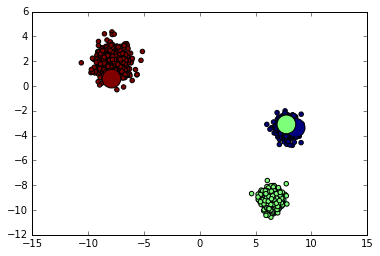

In [5]:
K = 3

np.random.seed(0)
# initize the centroids
def init_random(X, K):
    center_index = np.random.choice(range(X.shape[0]), K)
    centroids = X[center_index,:]
    return centroids

centroids = init_random(X, K)
scatter(X, answer, centroids=centroids)

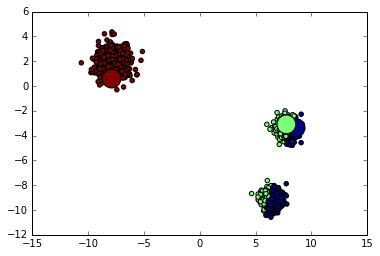

In [6]:
# assign to the clusters (E-step)
def get_assignments(X, centroids):
    dist = pairwise_distances(X, centroids)
    assign = np.argmin(dist,axis=1)
    return assign

y = get_assignments(X, centroids)
scatter(X, y, centroids=centroids)

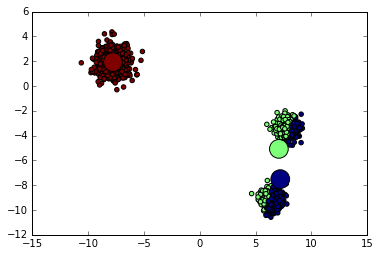

In [7]:
# compute the new centroids (M-step)
def get_centroids(X, assignments):
    centroids = []
    for i in np.unique(assignments):
        centroids.append(X[assignments==i].mean(axis=0))     
    return np.array(centroids)

centroids = get_centroids(X, y)
scatter(X, y, centroids=centroids)

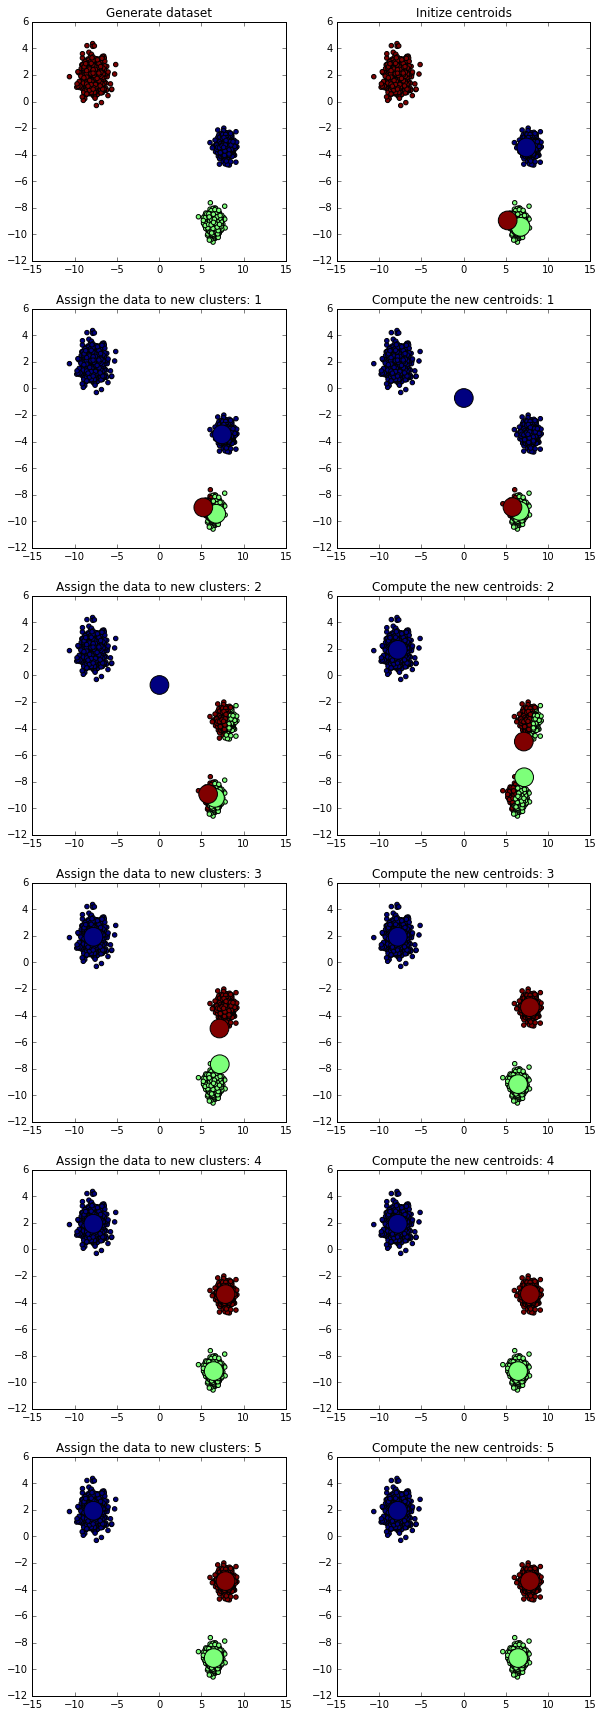

In [8]:
# A whole process, from start

n_iterations = 5
_, axes = plt.subplots(n_iterations+1, 2,figsize=(10,5*(n_iterations+1)))

scatter(X, answer, ax=axes[0,0])
axes[0,0].set_title('Generate dataset')

centroids = init_random(X, K)
scatter(X, answer, ax=axes[0,1], centroids=centroids)
axes[0,1].set_title('Initize centroids')

for i in range(1, n_iterations+1):
    y = get_assignments(X, centroids)
    scatter(X, y, ax=axes[i,0], centroids=centroids)
    axes[i,0].set_title('Assign the data to new clusters: %s' % i)
    
    centroids = get_centroids(X, y)
    scatter(X, y, ax=axes[i,1], centroids=centroids)
    axes[i,1].set_title('Compute the new centroids: %s' % i)

In [9]:
def KMeans(X, centroids, n_iterations=5, axes=None):
    if axes is not None:
        axes = axes.flatten()
    for i in range(n_iterations):
        assignments = get_assignments(X, centroids)
        centroids = get_centroids(X, assignments)
        if axes is not None:
            scatter(X, assignments, ax=axes[i], centroids=centroids)
            axes[i].set_title(i)
    return assignments, centroids

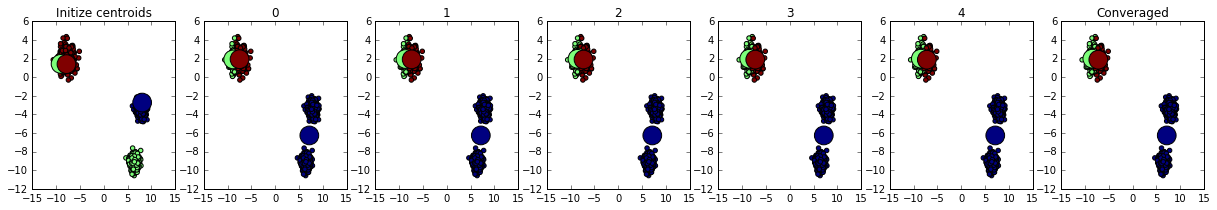

In [10]:
# But it's very possible to get the local minimum with random initization

np.random.seed(100)
n_iterations = 5
_, axes = plt.subplots(1, 7, figsize=(21,3))

centroids = init_random(X, K)
scatter(X, answer, ax=axes[0], centroids=centroids)
axes[0].set_title('Initize centroids')

y, centroids = KMeans(X, centroids,axes=axes[1:-1], n_iterations=n_iterations)
scatter(X, y, ax=axes[-1], centroids=centroids)
axes[-1].set_title('Converaged')

# Initize the centroids with "KMeans++"

In [11]:
def init_kmeans_plus_plus(X, K):
    '''Choose the next centroids with a prior of distance.'''
    assert K>=2, "So you want to make 1 cluster?"
    compute_distance = lambda X, c: pairwise_distances(X, c).min(axis=1)
    # get the first centroid
    centroids = [X[np.random.choice(range(X.shape[0])),:]]
    # choice next
    for _ in range(K-1):
        proba = compute_distance(X,centroids)**2
        proba /= proba.sum()
        centroids.append(X[np.random.choice(range(X.shape[0]), p=proba)])      
    return np.array(centroids)

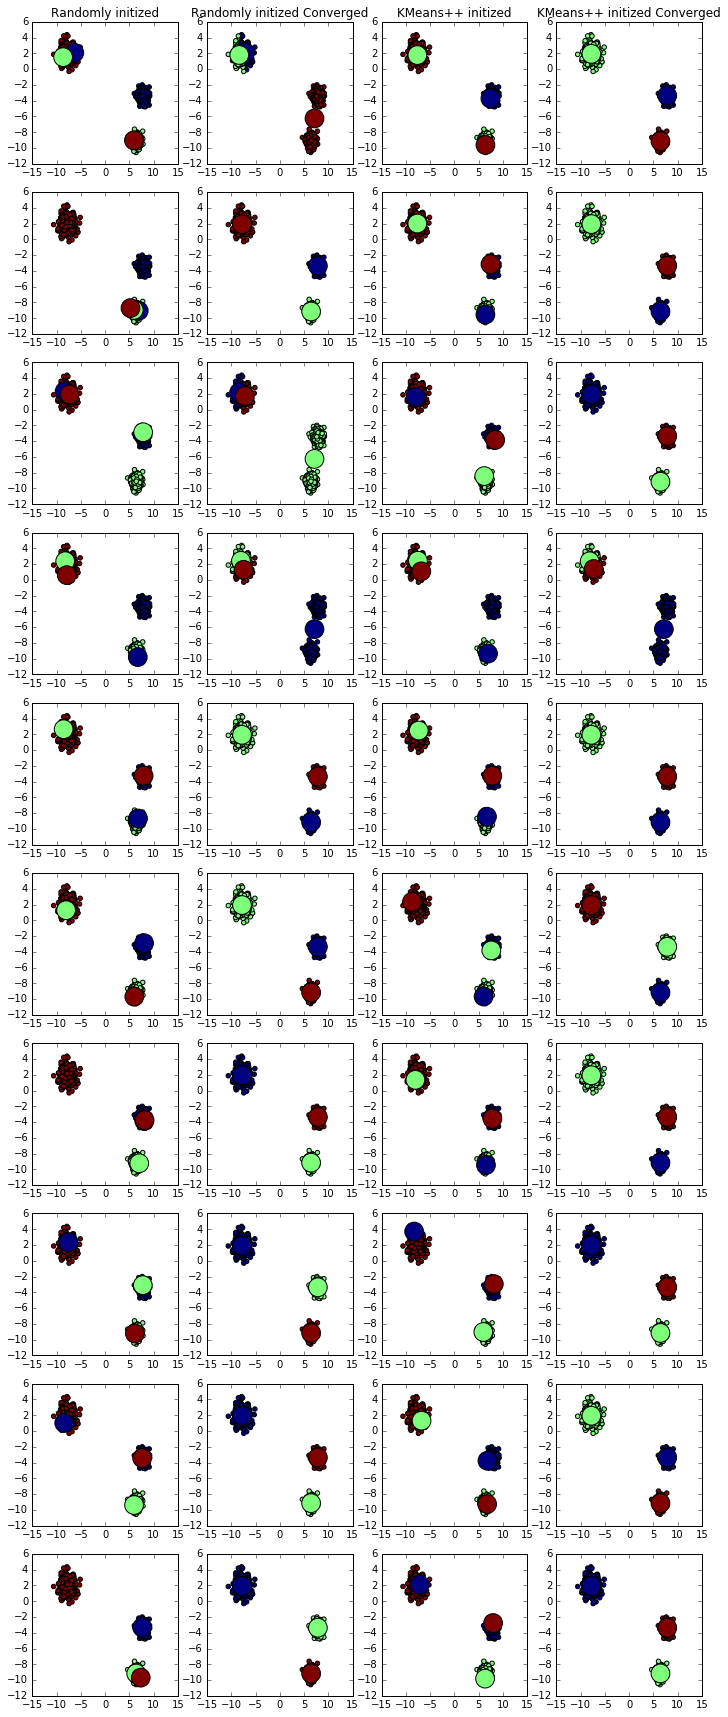

In [12]:
# kmeans++ initization is much better (the centroids are far from each other), which leads to better converge.
# Note: kmeans++ may still lead to local minimum
np.random.seed(1001)
n_tests = 10
_, axes = plt.subplots(10,4, figsize=(12,3*n_tests))
axes[0,0].set_title('Randomly initized')
axes[0,1].set_title('Randomly initized Converged')
axes[0,2].set_title('KMeans++ initized')
axes[0,3].set_title('KMeans++ initized Converged')


for i in range(n_tests):
    centroids = init_random(X, K)
    scatter(X, answer, ax=axes[i,0], centroids=centroids)
    y, centroids = KMeans(X, centroids)
    scatter(X, y, ax=axes[i,1], centroids=centroids)
    
    centroids = init_kmeans_plus_plus(X, K)
    scatter(X, answer, ax=axes[i,2], centroids=centroids)
    y, centroids = KMeans(X, centroids)
    scatter(X, y, ax=axes[i,3], centroids=centroids)